In [1]:
from cv2 import illuminationChange
import statistics
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import math
import scipy.io as sc
import netCDF4 as nc
import os, glob
import matplotlib.animation as manimation
from IPython.display import HTML
from matplotlib import rc
from matplotlib import cm
import sys
import pickle

def make_netcdffile_fromcross(time_start, time_end, time_gap, x_spacing, path, output_name, del_files): #output netcdf file with variable across time steps from dump files
    float_type = 'f4'
    float_type1 = 'i2'
    time_ind_total = int((time_end-time_start)/time_gap) + 1
    time = np.linspace(time_start,time_end,time_ind_total)
    main_variable=['qr','ql','couvreux','bc']
    attribute=['path','up','base']
    cross_section='.xy.'
    filename = path+main_variable[0] + attribute[0] + cross_section + str(format(int(time[0]),'07d'))
    fid=open(filename,'rb')
    x_length = int(np.sqrt(len(np.fromfile(fid))))
    x=np.linspace(x_spacing,x_length*x_spacing,x_length)
    y=np.linspace(x_spacing,x_length*x_spacing,x_length)
    nvar=3
    fid.close()
    if os.path.exists(path+output_name):
        os.remove(path+output_name)
    nc_file = nc.Dataset(path+output_name, mode="w", datamodel="NETCDF4", clobber=False)
    nc_file.createDimension("x", x_length)
    nc_file.createDimension("y", x_length)
    nc_file.createDimension("t", time_ind_total)
    nc_file.createDimension("nvar",nvar)
    nc_x = nc_file.createVariable("x", float_type, ("x"))
    nc_y = nc_file.createVariable("y", float_type, ("y"))
    nc_t = nc_file.createVariable("t", float_type, ("t"))
    nc_nvar = nc_file.createVariable("nvar", int, ("nvar"))
    nc_multiplying_factor = nc_file.createVariable("multiplying_factor", float_type1, ("1"))

    for j in range(0,len(main_variable)-1):
        var_name = main_variable[j]
        locals()[var_name] = np.zeros((x_length,x_length,time_ind_total,nvar))
        locals()['nc_'+var_name] = nc_file.createVariable(var_name, float_type, ("x","y","t","nvar"))  
        for k in range(0,len(attribute)):                  
            for i in range(0,time_ind_total):
                filename = path+main_variable[j] + attribute[k] + cross_section + str(format(int(time[i]),'07d'))
                fid=open(filename,'rb')
                var = np.fromfile(fid)
                if k==0:
                    var = np.around(var * multiplying_factor);
                locals()[var_name][:,:,i,k]=np.reshape(var,[x_length,x_length])
                fid.close()
        locals()[var_name]=locals()[var_name].astype(np.int16)
        locals()['nc_'+var_name][:] = locals()[var_name][:]
    
    var_name = main_variable[3]
    locals()[var_name] = np.zeros((x_length,x_length,time_ind_total,nvar+1))
    locals()[var_name][:,:,:,0:3] = locals()[main_variable[np.where(main_variable=='ql')]]
    locals()['nc_'+var_name] = nc_file.createVariable(var_name, float_type1, ("x","y","t","nvar"))

    for i in range(0,time_ind_total):
        filename = path+main_variable[3] +attribute[0]+ cross_section + str(format(int(time[i]),'07d'))
        fid=open(filename,'rb')
        var = np.fromfile(fid)
        var = np.around(var * multiplying_factor);
        locals()[var_name][:,:,i,4]=np.reshape(var,[x_length,x_length])
        fid.close()
    locals()[var_name]=locals()[var_name].astype(np.int16)
    locals()['nc_'+var_name][:] = locals()[var_name][:]




    nc_x [:] = x[:]
    nc_y [:] = y[:]
    nc_t [:] = time[:]
    nc_nvar [:]=nvar 
    nc_multiplying_factor = multiplying_factor
    nc_file.close()
    if del_files:
        #files = ["u", "v", "w", "thl", "time", "qr", "ql", "couv", "grid", "nr","qt","therm","bc"]
        files = ["path","up","base.xy"]
        for file in os.listdir(path):
            for i in range(0,len(files)):
                if file.find(files[i])!=-1: 
                    os.remove(path+file)
                #rm u* v* w* thl* time* qr* ql* couv* grid* nr* qt* therm* 
##########################################################################################
def converttoarray_cell(cells):
    total=0;
    for i in range(0,len(cells)):
        total = total + cells[i].nelements
    cell_array = np.zeros((9,total))
    total=0;
    for i in range(0,len(cells)):
        for n in range(0,cells[i].nelements):
            cell_array[0:3,total] = [cells[i].location[0][n],cells[i].location[1][n],cells[i].location[2][n]];
            cell_array[3:6,total] = [cells[i].value[0][n],cells[i].value[1][n],cells[i].value[2][n]];
            cell_array[6,total] = cells[i].id
            total = total+1
        if cells[i].nparents>0:
            for npar in range(0,cells[i].nparents):
                cell_array[7,total-cells[i].nelements+npar-1] = cells[i].parents[npar].id + 1
        if cells[i].nchildren>0:
            for nchild in range(0,cells[i].nchildren):
                cell_array[8,total-cells[i].nelements+nchild-1] = cells[i].children[nchild].id + 1

    return cell_array;
###########################################################################################
def writeout_netcdf(cloud,core,rain,thermal,properties):

    if os.path.exists(nc_save_path+nc_output_filename):
        os.remove(nc_save_path+nc_output_filename)
    
    nc_file = nc.Dataset(nc_save_path+nc_output_filename,mode="w", datamodel="NETCDF4", clobber=False)
    float_type = 'f4'

    nc_file.createDimension("properties",len(properties))
    nc_properties = nc_file.createVariable("properties",str,("properties"))
    
    if len(cloud)>0:
        cloud_length = np.linspace(0,len(cloud[1,:])-1,len(cloud[1,:]))
        nc_file.createDimension("cloud_length",len(cloud_length))
        nc_cloud_length = nc_file.createVariable("cloud_length",float_type,("cloud_length"))
        nc_cloud = nc_file.createVariable("cloud",float_type,("properties","cloud_length"))
        nc_cloud_length[:] = cloud_length[:]
        nc_cloud [:] = cloud [:]
    
    if len(core)>0:
        core_length = np.linspace(0,len(core[1,:])-1,len(core[1,:]))
        nc_file.createDimension("core_length",len(core_length))
        nc_core_length = nc_file.createVariable("core_length",float_type,("core_length"))
        nc_core = nc_file.createVariable("core",float_type,("properties","core_length"))
        nc_core_length[:] = core_length[:]
        nc_core [:] = core [:]

    if len(rain)>0:    
        rain_length = np.linspace(0,len(rain[1,:])-1,len(rain[1,:]))
        nc_file.createDimension("rain_length",len(rain_length))
        nc_rain_length = nc_file.createVariable("rain_length",float_type,("rain_length"))
        nc_rain = nc_file.createVariable("rain",float_type,("properties","rain_length"))
        nc_rain_length[:] = rain_length[:]
        nc_rain [:] = rain [:]
    
    if len(thermal)>0:
        thermal_length = np.linspace(0,len(thermal[1,:])-1,len(thermal[1,:]))
        nc_file.createDimension("thermal_length",len(thermal_length))
        nc_thermal_length = nc_file.createVariable("thermal_length",float_type,("thermal_length"))
        nc_thermal = nc_file.createVariable("thermal",float_type,("properties","thermal_length"))
        nc_thermal_length[:] = thermal_length[:]
        nc_thermal [:] = thermal [:]
    
    nc_properties = properties
    
    nc_file.close()
        
###########################################################################################
def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path)
    var=all_data[variable_name].values
    if variable_name=='bc':
        variable=np.zeros((len(var[:,0,0]),len(var[0,:,0]),len(var[0,0,:]),3))
        variable[:,:,:,0] = var
    else:
        variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['t'].values
    return variable, x, y, t;    
##########################################################################################
def find_boolean(variable, threshold_criteria, i_tstart,iscore): #variable is f(i, j, t): --> outputs boolean -1 (unsatisfied) 0 (satisfied) 
    boolean = np.zeros(( len(variable[:,0,0,0]), len(variable[0,:,0,0]), len(variable[0,0,:,0])))
    boolean = -1
    if iscore:
        ql_path = variable[:,:,:,0]
        core_path = variable[:,:,:,3]
        boolean = np.where(variable[:,:,:,0] >ql_threshold and variable[:,:,:,3]>bc_threshold \
            and variable[:,:,:,ibase]<(0.5*max(variable[:,:,:,ibase])+0.5*max(variable[:,:,:,itop])),0,-1)
    else:
        boolean = np.where(variable[:,:,:,ipath]>threshold_criteria,0,-1)

    if i_tstart>0:
        boolean[:,:,0:i_tstart-1] = -1
    return boolean;
##########################################################################################
class cell:
    def __init__(self, id):
        self.id = id
        self.value = [[],[],[]]
        self.location = [[],[],[]]
        self.nelements = 0
        self.nelements_local = 0
        self.nchildren = 0
        self.nparents = 0
        self.nsiblings = 0
        self.nsplitters = 0
        self.parents = []
        self.children = []
        self.splitters = []

    def add_elements(self, i, j, k, var_values):
        self.location[0].append(i)
        self.location[1].append(j)
        self.location[2].append(k)
        self.value[0].append(var_values[0])
        self.value[1].append(var_values[1])
        self.value[2].append(var_values[2])
        self.nelements = self.nelements + 1
        self.nelements_local = self.nelements_local + 1
    def __del__(self):
        return
########################################################################################
def identify_elements_in_cell(i,j,k,new_cell):  #input the ijk at which boolean is satisfied along with boolean and new cell created 

    global oldcell,oi,oj,ok,booli;
    new_cell.add_elements(i,j,k,cell_variable[i,j,k,:])
    booli[i,j,k] = -2

    ii=i-1; jj=j; kk=k; #look west
    if ii<0:
       ii = nx-1
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==1:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)  

    ii=i+1; jj=j; kk=k;  #look east
    if ii>nx-1:
       ii = 0
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==2:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)  

    ii=i; jj=j+1; kk=k;  #look north
    if jj>ny-1:
        jj = 0
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==3:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)  

    ii=i; jj=j-1; kk=k;  #look south
    if jj<0:
       jj = ny-1
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==4:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)  

    ii=i; jj=j; kk=min(k+1,nt-1);  #look forward
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==5:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)     

    ii=i; jj=j; kk=max(k-1,0);  #look backward
    if (booli[ii,jj,kk] == 0) and \
      ((cell_variable[i,j,k,ibase] <= cell_variable[ii,jj,kk,iup])\
      and (cell_variable[i,j,k,iup] >= cell_variable[ii,jj,kk,ibase])) :
        if new_cell.nelements_local>nmaxelems and recursion_point==6:
            oldcell = True;
            oi.append(ii);oj.append(jj);ok.append(kk);
        else:
            identify_elements_in_cell(ii,jj,kk,new_cell)  

#################################################################################################
def create_new_cell(variable,bool):                                # input the boolean and the variable, output is the cells tracked (i,j,t) based on boolean 
    cell_number = 0;
    global booli,cell_variable,nx,ny,nt,oldcell,flag,oi,oj,ok;
    nx = len(variable[:,0,0,0])
    ny = len(variable[0,:,0,0])
    nt = len(variable[0,0,:,0])
    booli=bool;cell_variable = variable;
    test=0; 
    variable_cells = []
    for k in range(0,nt):
        for j in range(0,ny):
            for i in range(0,nx):
                if booli[i,j,k]==0: 
                    oldcell=False;oi=[];oj=[];ok=[];
                    new_cell=cell(cell_number) 
                    identify_elements_in_cell(i,j,k,new_cell)
                    ii=oi;jj=oj;kk=ok;
                    while oldcell:
                        oldcell=False;oi=[];oj=[];ok=[];
                        test=test+1
                        new_cell.nelements_local = 0;
                        for n in range(0,len(ii)):
                            if new_cell.nelements_local<nmaxelems:
                                identify_elements_in_cell(ii[n],jj[n],kk[n],new_cell)
                            else:
                                oi.append(ii[n]);oj.append(jj[n]);ok.append(kk[n]);
                                oldcell=True;
                        ii=oi;jj=oj;kk=ok;              
                    if new_cell.nelements>=nminelems:
                        variable_cells.append(new_cell)
                        variable_cells[cell_number].id = cell_number
                        cell_number = cell_number + 1
                        if variable_cells[cell_number-1].nelements>print_nelements:
                            print("Identifying elements of Cell:",variable_cells[cell_number-1].id)
                    else:
                        del new_cell;
                    
    print("Number of While Recursions:",test)
    return variable_cells, cell_number;
##################################################################################################
def insert_cell(cells,new_cell,variable_number):
    new_cell.id - variable_number
    cells.append(new_cell)
    for n_cells in range(0,len(cells)):
        if cells[n_cells].id >= variable_number:
            cells[n_cells].id = cells[n_cells].id + 1;
##################################################################################################
def fill_parent_array(cells,nx,ny,nt):                                     #fills parent_array variable with id numbers of cells corresponding to each grid point 
    parent_array=np.zeros((nx,ny,nt))                             # fills base and up with values of base and up at those grid points
    base=np.zeros((nx,ny,nt))
    up=np.zeros((nx,ny,nt))
    for c in range(0,len(cells)):
        for n in range(0,cells[c].nelements):
            parent_array[cells[c].location[0][n],cells[c].location[1][n],cells[c].location[2][n]]\
                        = cells[c].id + 1
            base[cells[c].location[0][n],cells[c].location[1][n],cells[c].location[2][n]]\
                        = cells[c].value[ibase][n]
            up[cells[c].location[0][n],cells[c].location[1][n],cells[c].location[2][n]]\
                        = cells[c].value[iup][n]
    return parent_array,base,up;
#################################################################################################
def find_parent(cells,parent_cells,parent_array,base,up):
    lnewparent=False
    for n in range(0,len(cells)):
        for nn in range(0,cells[n].nelements):
            i = cells[n].location[0][nn]
            j = cells[n].location[1][nn]
            t = cells[n].location[2][nn]
            if parent_array[i,j,t] > 0:
                if base[i,j,t] <= cells[n].value[iup][cells[n].nelements-1] and up[i,j,t] >= cells[n].value[ibase][cells[n].nelements-1]:
                    lnewparent = True
                    for np in range(0,cells[n].nparents):
                        if cells[n].nparents>0 and (cells[n].parents[np].id == parent_array[i,j,t]-1):
                            lnewparent=False
                    if lnewparent:
                        cells[n].parents.append(parent_cells[int(parent_array[i,j,t]-1)])
                        parent_cells[int(parent_array[i,j,t]-1)].children.append(cells[n])                       
                        cells[n].nparents = cells[n].nparents + 1
                        parent_cells[int(parent_array[i,j,t]-1)].nchildren = \
                        parent_cells[int(parent_array[i,j,t]-1)].nchildren + 1
    return cells,parent_cells;
#################################################################################################
def splitcell(cells, parent_cells, parent_array):
    
    global booli;
    for n_cells in range(0,len(cells)):
        list_var = np.zeros((4,cells[n_cells].nelements)); # contains indices i*j*t*n_splits for each element
        endlist = np.zeros((4,cells[n_cells].nelements));  # contains for all elements consequtively
        newlist = np.zeros((4,cells[n_cells].nelements));  #
        old_cell=cells[n_cells];
        nlist = 0;                                         # number of splits for each element
        nnewlist = 0; 
        newlist=0; 
        nendlist = 0;
        cbstep = 300;
        for n_elems in range(0,cells[n_cells].nelements):
            i=cells[n_cells].location[0][n_elems]; j=cells[n_cells].location[1][n_elems]; t=cells[n_cells].location[2][n_elems];
            if parent_array[i,j,t]!=0:
                lnewparent=True
                for n_spl in range(0,cells[n_cells].nsplitters):
                    if cells[n_cells].splitters[n_spl].parents[0].id==parent_array[i,j,t]:
                        lnewparent=False
                        break;
                if (lnewparent and (cells[n_cells].nsplitters>=1)):
                    if (parent_cells[parent_array[i,j,t]].nelements < minparentelems):
                        lnewparent = False
                    elif cells[n_cells].splitters[0].parents[0].nelements < minparentelems:
                        cells[n_cells].nsplitters=0;
                        parent_cells[parent_array[i,j,t]].nchildren = 0;
                if lnewparent:
                    cells[n_cells].splitters[cells[n_cells].nsplitters-1].parents.append(parent_cells[parent_array[i,j,t]])
                    parent_cells[parent_array[i,j,t]].nchildren = parent_cells[parent_array[i,j,t]].nchildren + 1;
                    parent_cells[parent_array[i,j,t]].children[parent_cells[parent_array[i,j,t]].nchildren].parents.append(cells[n_cells])
        if old_cell.nsplitters >= 2:
            nr = np.zeros((old_cell.nesplitters))
            for n_old in range(0,old_cell.nelements):
                i=cells[n_cells].location[0][n_old]; j=cells[n_cells].location[1][n_old]; t=cells[n_old].location[2][n_old];
                if parent_array[i,j,t]!=0:
                    for n_spl in range(0,old_cell.nsplitters):
                        if cells[n_cells].splitters[n_spl].parents[0].id==parent_array[i,j,t]:
                            nlist=nlist+1;
                            booli[i,j,t] = n_spl;
                            list_var[0,nlist] = i;
                            list_var[1,nlist] = j;
                            list_var[2,nlist] = t;
                            list_var[3,nlist] = n_spl;
                            nr[n_spl] = nr[n_spl] + 1                #indicator for how many ijts per splitter 
                            break
                continue
            endlist[:,nendlist:nendlist+nlist] = list_var[:,0:nlist]
            nendlist = nendlist + nlist 
            max_iteration = 1000/x_spacing
            for iteration in range(0,max_iteration):
                if nlist == 0:
                    exit
                nnewlist = 0;
                for n_nlist in range(0,nlist):
                    i=list_var[0,n_nlist]; j=list_var[1,n_nlist]; t=list_var[2,n_nlist];

                    ii=i-1; 
                    if ii<0:
                        ii = nx-1
                    if booli[ii,j,t]==-2 and (cell_variable[ii,j,t,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[ii,j,t] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1

                    ii=i+1; 
                    if ii>nx-1:
                        ii = 0
                    if booli[ii,j,t]==-2 and (cell_variable[ii,j,t,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[ii,j,t] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1    

                    jj=j-1; 
                    if jj<0:
                        jj = ny-1
                    if booli[i,jj,t]==-2 and (cell_variable[i,jj,t,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[i,jj,t] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1 

                    jj=j+1; 
                    if jj>ny-1:
                        jj = 0
                    if booli[i,jj,t]==-2 and (cell_variable[i,jj,t,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[i,jj,t] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1 

                    tt=min(t+1,nt-1);
                    if booli[i,j,tt]==-2 and (cell_variable[i,j,tt,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[i,j,tt] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1 

                    tt=max(t-1,0);
                    if booli[i,j,tt]==-2 and (cell_variable[i,j,tt,ibase] < cell_variable[i,j,t,ibase] + cbstep):
                        booli[i,j,tt] = -1;
                        nnewlist = nnewlist + 1
                        newlist[0,nnewlist] = ii; newlist[1,nnewlist] = j; newlist[2,nnewlist] = t;
                        newlist[3,nnewlist] = list_var[3,n_nlist]
                        nr[list_var[3,n_nlist]] = nr[list_var[3,n_nlist]] + 1  
                nlist = nnewlist
                list_var[:,0:nnewlist-1] = newlist[:,0:nnewlist-1]
                endlist[:,nendlist:nendlist+nlist-1] = list_var[:,0:nlist-1]
                nendlist = nendlist + nlist
            if nendlist < old_cell.nelements:
                lpassive = False
                for n_old in range(0,old_cell.nelements):
                    i=cells[n_cells].location[0][n_old]; j=cells[n_cells].location[1][n_old]; t=cells[n_old].location[2][n_old];
                    if booli[i,j,t]== -2:
                        booli[i,j,t]= -1
                        nendlist = nendlist + 1
                        nr[old_cell.nsplitters] = nr[old_cell.nsplitters] + 1
                        endlist[0,nendlist] = i; endlist[1,nendlist] = j; endlist[2,nendlist] = t;
                        endlist[3,nendlist] = old_cell.nsplitters
            else:
                lpassive = False
            newcells = np.zeros((old_cell.nsplitters)) 
            for n_old in range(0,old_cell.nsplitters):
                new_cell = cell(old_cell.id + n_old + 1)
                a=0;

#################################################################################################
def run_tracking(tracked_param,param_threshold):
    global nx,ny,nt,x,y,t;
    [tracked_variable,x,y,t] = retrieve_variable(tracked_param,nc_store_path+nc_filename);
    nx = len(tracked_variable[:,0,0,0]); ny = len(tracked_variable[0,:,0,0]); 
    nt = len(tracked_variable[0,0,:,0]);

    if tracked_param=='bc':
        bool = find_boolean(tracked_variable,param_threshold,t_start,True)
    else:
        bool = find_boolean(tracked_variable,param_threshold,t_start,False)
    
    [cells,cell_number] = create_new_cell(tracked_variable,bool);
    print("Number of Cells in ",tracked_param,":",len(cells))
    return cells,cell_number;
##################################################################################################
def make_animation_cells(x,y,all_cells,nt,minimum_elements,p_c):
    fig, ax = pl.subplots()
    cell_plot=np.zeros((len(x),len(y),nt));
    cell_parent_plot=np.zeros((len(x),len(y),nt));
    cell_children_plot=np.zeros((len(x),len(y),nt));
    count=0
    cells=[]
    for i in range(0,len(all_cells)):
        if all_cells[i].nelements>minimum_elements:
            cells.append(all_cells[i])
            count=count+1
    rand_series=np.random.randint(count, size=(count))
    for i in range (0,len(cells)):     
        for n in range(0,cells[i].nelements):      
            cell_plot[cells[i].location[0][n],cells[i].location[1][n],cells[i].location[2][n]] = rand_series[i]
    if p_c=='p' or p_c=='c_p':
        for i in range (0,len(cells)):
            if cells[i].nparents>0:
                for npar in range(0,cells[i].nparents):
                    for n in range(0,cells[i].parents[npar].nelements):      
                        cell_parent_plot[cells[i].parents[npar].location[0][n],cells[i].parents[npar].location[1][n],(cells[i].parents[npar].location[2][n])] = rand_series[i]
    if p_c=='c'or p_c=='c_p':
        for i in range (0,len(cells)):
            if cells[i].nchildren>0:
                for nchild in range(0,cells[i].nchildren):
                    for n in range(0,cells[i].children[nchild].nelements):      
                        cell_children_plot[cells[i].children[nchild].location[0][n],cells[i].children[nchild].location[1][n],(cells[i].children[nchild].location[2][n])] = rand_series[i]
    if count>nmaxcells:
        levels=np.linspace(0,count,(count+1)/math.ceil(count/nmaxcells))
    else:
        levels=np.linspace(0,count,count+1)
    def animate(i):
        ax.clear()
        if p_c=='p':
            ax.contourf(x,y,cell_parent_plot[:,:,i],levels=levels,cmap=cm.tab20b)
            ax.contour(x,y,cell_plot[:,:,i],levels=levels,cmap=cm.tab20b,linestyles='solid',linewidth=1.5)
        elif p_c=='c':
            ax.contourf(x,y,cell_plot[:,:,i],levels=levels,cmap=cm.tab20b)
            ax.contour(x,y,cell_children_plot[:,:,i],levels=levels,cmap=cm.tab20b,linestyles='solid')
        elif p_c=='':
            ax.contour(x,y,cell_plot[:,:,i],levels=levels,cmap=cm.flag)
        elif p_c=='c_p':
            ax.contourf(x,y,cell_plot[:,:,i],levels=levels,cmap=cm.tab20b)
            ax.contour(x,y,cell_children_plot[:,:,i],levels=levels,cmap=cm.tab20b,linestyles='solid')
            ax.contour(x,y,cell_parent_plot[:,:,i],levels=levels,cmap=cm.tab20b,linestyles='dashed')   
        return ax;
    ani = manimation.FuncAnimation(fig,animate,frames=nt,repeat=True)
    pl.show()
    HTML(ani.to_jshtml())
    pl.rcParams["animation.html"] = "jshtml"
    return ani
##################################################################################################
def make_animation_contour(x,y,variable,nt):
    fig, ax = pl.subplots()
    def animate(i):
        ax.clear()
        CS = ax.contour(x,y,variable[:,:,i])
        ax.clabel(CS, inline=True, fontsize=10)
        return ax;
        
    ani = manimation.FuncAnimation(fig,animate,frames=nt,repeat=False)
    pl.show()
    HTML(ani.to_jshtml())
    pl.rcParams["animation.html"] = "jshtml"
    return ani
#################################################################################################
def main_fun():
    global rain,thermal,core,cloud;

    [rain,rain_ncells]= run_tracking('qr',qr_threshold)
    
    [cloud,cloud_ncells] = run_tracking('ql',ql_threshold)
    
    print('Finding parent for Rain')
    [parent_array,base,up] = fill_parent_array(cloud,nx,ny,nt)
    [rain,cloud] = find_parent(rain,cloud,parent_array,base,up)
    
    print('Tracking thermals')
    [thermal,thermal_ncells] = run_tracking('couvreux',couv_threshold)
    
    print('Finding parent for Cloud')
    del parent_array,base,up;
    [parent_array,base,up] = fill_parent_array(thermal,nx,ny,nt)
    [cloud,thermal] = find_parent(cloud,thermal,parent_array,base,up);

    #[core,core_ncells,x,y,t] = run_tracking('bc',bc_threshold)


    array_description = ['x','y','t','path','top','base','cell_id','parent id','children id']
    rain_array = converttoarray_cell(rain);
    cloud_array = converttoarray_cell(cloud);
    thermal_array = converttoarray_cell(thermal)
    #core_array = converttoarray_cell(core)
    global ani1,ani2,ani3;
    ani1 = make_animation_cells(x,y,cloud,nt,2e6,'c')
    del rain,cloud,thermal;


    print('Writing arrays to netcdf')
    writeout_netcdf(cloud_array,[],rain_array,thermal_array,array_description)
    del rain_array,cloud_array,thermal_array;

    #pl.figure()
    #plot1=[]
    #for i in range(0,len(cloud)):
    #    plot1.append(cloud[i].nelements)
    #pl.plot(plot1)
    
    

    
    #cloud_bool = np.where(cloud_path[:,:,:,0]>ql_threshold,1,0)
    #ani2 = make_animation_contour(x,y,cloud_bool,nt)
    #ani3 = make_animation_cells(x,y,cloud,nt,500,'c')
    
###############################################################################################

nc_store_path='/data/rico_cloudtrack/cloudtrack_inputnc/'
nc_filename='cloudtrack_variables_1024_84k.nc'
nc_save_path='/data/rico_cloudtrack/cloudtrack_outputnc/'
nc_output_filename='savefile_1024_84k_06.nc'
ipath=0; iup=1; ibase=2
multiplying_factor=100;
qr_threshold = 0.01* multiplying_factor; ql_threshold = 0.07 * multiplying_factor;
couv_threshold = 0.05 * multiplying_factor; bc_threshold = 1 * multiplying_factor;
nminelems=5;nmaxcells=1500;minparentelems=25;
nmaxelems=3000; # recursion cutoff number
x_spacing=25;recursion_point=2;

t_start = 0; t_plot=7;print_nelements = 2e6;
sys.setrecursionlimit(20000)

#make_netcdffile_fromcross(24060,84000,60,x_spacing,nc_store_path,nc_filename,True)  
main_fun()
f = r"/data/rico_cloudtrack/cloudtrack_animations/animation_1024_84k_06.gif" 
writergif = manimation.PillowWriter(fps=5) 
ani1.save(f, writer=writergif)


ModuleNotFoundError: No module named 'cv2'

Setting Relations
starting statistics
Calculating statistics for 0
Calculating statistics for 1000
Calculating statistics for 2000
Calculating statistics for 3000
Calculating statistics for 4000
Calculating statistics for 5000
Calculating statistics for 6000
Calculating statistics for 7000
Calculating statistics for 8000
Calculating statistics for 9000
Calculating statistics for 10000
Calculating statistics for 11000
Calculating statistics for 12000
Calculating statistics for 13000
Calculating statistics for 14000
Calculating statistics for 15000
Calculating statistics for 16000
Calculating statistics for 17000
Calculating statistics for 18000
Calculating statistics for 19000
Calculating statistics for 20000
Calculating statistics for 21000
Calculating statistics for 22000
Calculating statistics for 23000
Calculating statistics for 24000
Calculating statistics for 25000
Calculating statistics for 26000
Calculating statistics for 27000
Calculating statistics for 28000
Calculating statis

/tmp/ipykernel_10464/1055917241.py:95: RuntimeWarning: invalid value encountered in true_divide
  rain_to_cloud = rain_total/cloud_total
/tmp/ipykernel_10464/1055917241.py:160: RuntimeWarning: invalid value encountered in double_scalars
  rain_base_atmax[i] = np.sum(rain_base[rain_time==i])/len(rain_base[rain_time==i]);
/tmp/ipykernel_10464/1055917241.py:162: RuntimeWarning: invalid value encountered in true_divide
  rain_ratio = rain_atmax/cloud_atmax


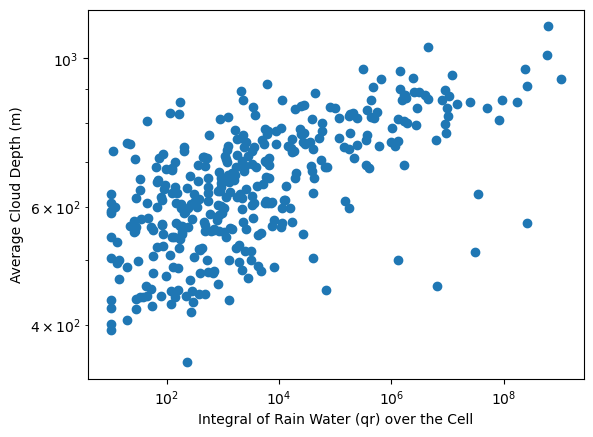

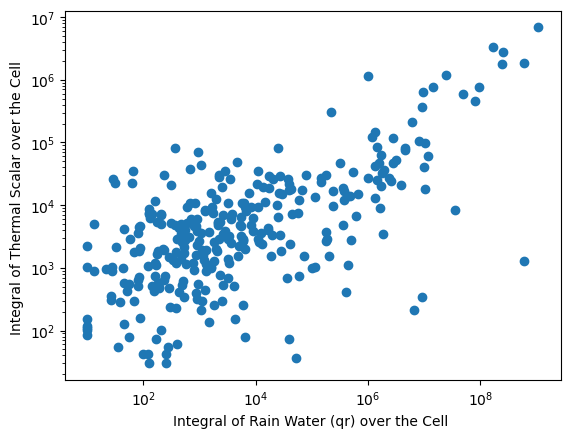

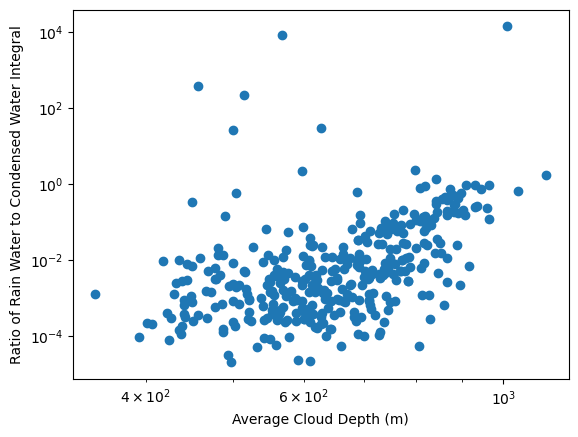

<Figure size 640x480 with 0 Axes>

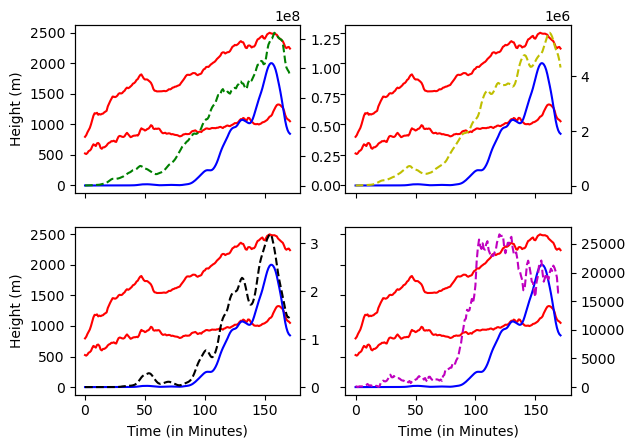

In [9]:
import statistics
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import math
import scipy as sc
from scipy import stats
import os, glob
import matplotlib.animation as manimation
from IPython.display import HTML
from matplotlib import rc
from matplotlib import cm
import sys
#import seaborn as sns

nc_save_path='/data/rico_cloudtrack/cloudtrack_outputnc/'
nc_output_filename='savefile_1024_84k_06.nc'

############################## indices of saved cell variables ########################################
icellid=6;ipath=3;iup=4;ibase=5;
iparent=7;ichildren=8;
ii=0;ij=1;ik=2;
rel_id=0;rel_elements=1;rel_relations=2;

############################## read netcdf file and open variable function ############################
def retrieve_variable(variable_name,netcdf_path): 
    all_data=xr.open_dataset(netcdf_path)
    variable=all_data[variable_name].values
    return variable; 
############################# set relation function ###################################################
def relation_array(ncells,cells,relation_index):
    cell_relations = np.zeros((ncells,3000))
    cell_relations[:,rel_id],cell_relations[:,rel_elements] = np.unique(cells[icellid,:],return_counts=True)
    for i in range(0,ncells):
        tot=0;
        if i>0:
            tot = int(np.sum(cell_relations[0:i-1,rel_elements])); 
        x = cells[relation_index,tot:tot+int(cell_relations[i,rel_elements])]
        y = x[x>0]
        cell_relations[i,rel_relations] = len(y)
        cell_relations[i,3:3+len(y)] = y-1
    cell_relations = cell_relations.astype(np.int32)
    return cell_relations;

################################### get variable arrays###############################

rain = retrieve_variable('rain',nc_save_path+nc_output_filename)
cloud = retrieve_variable('cloud',nc_save_path+nc_output_filename)
thermal = retrieve_variable('thermal',nc_save_path+nc_output_filename)

#################### declare x,y and t sizes and total cells in each array############

nx = int(max(cloud[ii,:])+1); ny = int(max(cloud[ij,:])+1); nt = int(max(cloud[ik,:])+1);
ncloud = int(max(cloud[icellid,:])+1); nrain = int(max(rain[icellid,:])+1); 
nthermal = int(max(thermal[icellid,:])+1);
print('Setting Relations')

################### retrieve relation arrays#########################################
cloud_children = relation_array(ncloud,cloud,ichildren)
cloud_parent = relation_array(ncloud,cloud,iparent)
rain_parent = relation_array(nrain,rain,iparent)
thermal_children = relation_array(nthermal,thermal,ichildren)

# 0 --> cloud ids; 1 --> cloud elements in time step; 2 --> nchildren; 3,4... --> children ids 

####################### statistics over entire cell and relation plots #######################
def dostatistics_overcell():
    global rain_total;
    cloud_total = np.zeros((ncloud)); cloud_depth = np.zeros((ncloud)); cloud_volume = np.zeros((ncloud)); 
    cloud_average = np.zeros((ncloud));
    rain_total = np.zeros((ncloud)); therm_total = np.zeros((ncloud))
    rain_instant = []
    print('starting statistics')
    for i in range(0,ncloud):
        if (i%1000) == 0:
            print('Calculating statistics for',i)
        if cloud_children[i,rel_elements]>nmincells and cloud_children[i,rel_relations]>0:
            tot = np.sum(cloud_children[0:i-1,rel_elements]); 
            x=np.sum(cloud[ipath,tot:tot+int(cloud_children[i,rel_elements])]); 
            y=np.sum(cloud[iup,tot:tot+int(cloud_children[i,rel_elements])]-cloud[ibase,tot:tot+int(cloud_children[i,rel_elements])]);
            cloud_total[i] = cloud_total[i] + x
            cloud_depth[i] = cloud_depth[i] + y/cloud_children[i,rel_elements]
            cloud_average[i] = cloud_total[i] / y;
            for nchild in range(0,(cloud_children[i,rel_relations])):
                j = int(cloud_children[i,3+nchild]); 
                tot = np.sum(rain_parent[0:j-1,rel_elements]); #find index of starting of cell
                x=np.sum(rain[3,tot:tot+int(rain_parent[j,rel_elements])]); #sum elements in cell 
                rain_total[i] = rain_total[i] + x
            for nparent in range(0,(cloud_parent[i,rel_relations])):
                j = int(cloud_parent[i,3+nparent]); 
                tot = np.sum(thermal_children[0:j-1,rel_elements]); #find index of starting of cell
                x=np.sum(thermal[ipath,tot:tot+int(thermal_children[j,rel_elements])]); #sum elements in cell 
                therm_total[i] = therm_total[i] + x
    rain_to_cloud = rain_total/cloud_total
    
    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(rain_total,cloud_depth)
    pl.xlabel('Integral of Rain Water (qr) over the Cell');
    pl.ylabel('Average Cloud Depth (m)');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    ax.scatter(rain_total,therm_total)
    pl.xlabel('Integral of Rain Water (qr) over the Cell ');
    pl.ylabel('Integral of Thermal Scalar over the Cell ');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_depth,rain_to_cloud)
    pl.xlabel('Average Cloud Depth (m)');
    pl.ylabel('Ratio of Rain Water to Condensed Water Integral');
    ax.set_yscale('log')
    ax.set_xscale('log')

########################## instantaneous stats of one cell ######################################
def dostatistics_singlecell(max_cell):
    global cloud_base_atmax, cloud_top_atmax, rain_atmax, rain_base_atmax, rain_sorted;
    global therm_atmax, cloud_nelements,cloud_atmax, rain_ratio;
    cloud_base_atmax = np.zeros((nt)); cloud_top_atmax = np.zeros((nt)); rain_atmax = np.zeros((nt)); 
    rain_base_atmax = np.zeros((nt)); therm_atmax = np.zeros((nt));
    cloud_nelements = np.zeros((nt)); cloud_atmax = np.zeros((nt));
    rain_sorted = np.sort(rain_total)[::-1]
    max_id = np.nonzero(rain_total==rain_sorted[max_cell])[0][0];
    #max_id = int(max_id_tuple[0])
    tot_c = np.sum(cloud_children[0:max_id-1,1]);  # starting index of given cell 
    x=cloud[2,tot_c:tot_c+cloud_children[max_id,1]];
    rain_child = []; rain_base = []
    rain_time = []
    for nchild in range(0,cloud_children[max_id,rel_relations]):
        j=(int(cloud_children[max_id,3+nchild]))
        tot_r = np.sum(rain_parent[0:j-1,1]);
        rain_child = np.concatenate([rain_child,rain[ipath,tot_r:tot_r+int(rain_parent[j,1])]])
        rain_base = np.concatenate([rain_base,rain[ibase,tot_r:tot_r+int(rain_parent[j,1])]])
        rain_time = np.concatenate([rain_time,rain[ik,tot_r:tot_r+int(rain_parent[j,1])]])
    therm_parent = [];therm_time=[]
    for nparent in range(0,cloud_parent[max_id,rel_relations]):
        j=(int(cloud_parent[max_id,3+nparent]))
        tot_r = np.sum(thermal_children[0:j-1,rel_elements]);
        therm_parent = np.concatenate([therm_parent,thermal[ipath,tot_r:tot_r+int(thermal_children[j,rel_elements])]])
        therm_time = np.concatenate([therm_time,thermal[ik,tot_r:tot_r+int(thermal_children[j,rel_elements])]])

    for i in range(0,nt):
        z = (x==i)
        if np.sum(z)>0:
            y = cloud[5,tot_c:tot_c+cloud_children[max_id,1]];
            cloud_base_atmax[i] = np.sum(y[z])/np.sum(z);
            yy = cloud[4,tot_c:tot_c+cloud_children[max_id,1]];
            cloud_top_atmax[i] = np.sum(yy[z])/np.sum(z);
            cloud_nelements[i] = np.sum(yy[z]-y[z]);
            y = cloud[ipath,tot_c:tot_c+cloud_children[max_id,1]];
            cloud_atmax[i] = np.sum(y[z]);
            rain_atmax[i] = np.sum(rain_child[rain_time==i]);
            therm_atmax[i] = np.sum(therm_parent[therm_time==i]);
            rain_base_atmax[i] = np.sum(rain_base[rain_time==i])/len(rain_base[rain_time==i]);
            #cloud_nelements[i] = np.sum(z);
    rain_ratio = rain_atmax/cloud_atmax
    rain_atmax = rain_atmax*2000/max(rain_atmax)
    
    pl.figure()
    fig, ax1=pl.subplots(2,2)
    ax1[0,0].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[0,0].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[0,0].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[0,0].twinx()
    ax2.plot(cloud_nelements[cloud_base_atmax>0],'g--')
    #pl.ylabel('Integral of Cloud Elements')

    ax1[0,1].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[0,1].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[0,1].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[0,1].twinx()
    ax2.plot(cloud_atmax[cloud_base_atmax>0],'y--')
    #pl.ylabel('Integral of Condensed Water')

    ax1[1,0].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[1,0].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[1,0].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[1,0].twinx()
    ax2.plot(rain_ratio[cloud_base_atmax>0],'k--')
    #pl.ylabel('qr/ql')

    ax1[1,1].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[1,1].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[1,1].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[1,1].twinx()
    ax2.plot(therm_atmax[cloud_base_atmax>0],'m--')
    #pl.ylabel('Integral of Thermal Scalar')

    for ax in ax1.flat:
        ax.set(xlabel='Time (in Minutes)', ylabel='Height (m)')
        ax.label_outer()
    pl.show()
############################## instantaneous stats over several cells ############################
def dostatistics_instantaneous():
    ncells=500;
    global cloud_instant,cloud_nelements_instant,rain_instant,therm_instant, rain_sorted, cloud_depth_instant;
    cloud_nelements_instant = np.zeros((nt*ncells)); cloud_instant = np.zeros((nt*ncells)); cloud_depth_instant = np.zeros((nt*ncells));
    rain_instant = np.zeros((nt*ncells)); therm_instant = np.zeros((nt*ncells));
    rain_sorted = np.sort(rain_total)[::-1]
    count=0;flag=0;
    if rain_cutoff>0:
        ncells=np.nonzero(rain_sorted==min(rain_sorted[rain_sorted>rain_cutoff]))[0][0];
    print(ncells);
    for iii in range(0,ncells):
        cell_id = np.nonzero(rain_total==rain_sorted[iii])[0][0];
        tot_c = np.sum(cloud_children[0:cell_id-1,1]);  # starting index of given cell 
        x=cloud[ik,tot_c:tot_c+cloud_children[cell_id,1]];
        rainpath_all = []; raintime_all = [];
        thermpath_all = [];thermtime_all=[]
        for nchild in range(0,cloud_children[cell_id,rel_relations]):
            j=(int(cloud_children[cell_id,3+nchild]))
            tot_r = np.sum(rain_parent[0:j-1,1]);
            rainpath_all = np.concatenate([rainpath_all,rain[ipath,tot_r:tot_r+int(rain_parent[j,rel_elements])]])
            raintime_all = np.concatenate([raintime_all,rain[ik,tot_r:tot_r+int(rain_parent[j,rel_elements])]])
        for nparent in range(0,cloud_parent[cell_id,rel_relations]):
            j=(int(cloud_parent[cell_id,3+nparent]))
            tot_r = np.sum(thermal_children[0:j-1,rel_elements]);
            thermpath_all = np.concatenate([thermpath_all,thermal[ipath,tot_r:tot_r+int(thermal_children[j,rel_elements])]])
            thermtime_all = np.concatenate([thermtime_all,thermal[ik,tot_r:tot_r+int(thermal_children[j,rel_elements])]])
        flag=0;
        for i in range(0,nt):
            z = (x==i); t_z = (thermtime_all==i);
            if np.sum(z)>0 and np.sum(t_z)>0:
                y = cloud[ibase,tot_c:tot_c+cloud_children[cell_id,rel_elements]];
                yy = cloud[iup,tot_c:tot_c+cloud_children[cell_id,rel_elements]];
                cloud_nelements_instant[count] = np.sum(yy[z]-y[z]);
                cloud_depth_instant[count] = cloud_nelements_instant[count] / np.sum(z)
                y = cloud[ipath,tot_c:tot_c+cloud_children[cell_id,1]];
                cloud_instant[count] = np.sum(y[z]);
                rain_instant[count] = np.sum(rainpath_all[raintime_all==i]);
                therm_instant[count] = np.sum(thermpath_all[t_z]);
                count = count+1
                #if before_rain and rain_instant[count]
    raintocloud = rain_instant/cloud_instant
    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_nelements_instant[rain_instant>rain_lim],cloud_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Cloud Volume at t');
    pl.ylabel('Integral of Condensate Water (ql) over the Cell at t');
    #ax.set_yscale('log')
    #ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(rain_instant[rain_instant>rain_lim],cloud_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Rainwater (qr) over the Cell at t');
    pl.ylabel('Integral of Condensate Water (ql) over the Cell at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(rain_instant[rain_instant>rain_lim],cloud_depth_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Rainwater (qr) over the Cell at t');
    pl.ylabel('Average Cloud Depth at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(rain_instant[rain_instant>rain_lim],cloud_depth_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Rainwater (qr) over the Cell at t');
    pl.ylabel('Average Cloud Depth at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_instant[rain_instant>rain_lim],therm_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Condensate Water (ql) over the Cell at t');
    pl.ylabel('Integral of Thermal Scalar over the Cell at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_nelements_instant[rain_instant>rain_lim],therm_instant[rain_instant>rain_lim])
    pl.xlabel('Integral of Cloud Volume at t');
    pl.ylabel('Integral of Thermal Scalar over the Cell at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

#    fig = pl.figure()
#    ax = pl.gca()
#    pl.scatter(rain_instant[rain_instant>rain_lim],therm_instant[rain_instant>rain_lim])
#    pl.xlabel('Integral of Rain Water (qr) at t');
#    pl.ylabel('Integral of Thermal Scalar over the Cell at t');
#    ax.set_yscale('log')
#    ax.set_xscale('log')
#############################################################################################    

nmincells=1e3
dostatistics_overcell()
maximum_cell=1; 
dostatistics_singlecell(maximum_cell)
rain_lim=0; rain_cutoff=1e5; before_rain=True
#dostatistics_instantaneous()



<Figure size 432x288 with 0 Axes>

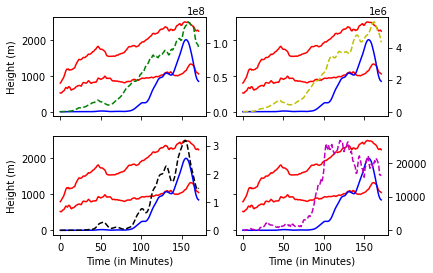

In [10]:
    pl.figure()
    fig, ax1=pl.subplots(2,2)
    ax1[0,0].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[0,0].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[0,0].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[0,0].twinx()
    ax2.plot(cloud_nelements[cloud_base_atmax>0],'g--')
    #pl.ylabel('Integral of Cloud Elements')

    ax1[0,1].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[0,1].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[0,1].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[0,1].twinx()
    ax2.plot(cloud_atmax[cloud_base_atmax>0],'y--')
    #pl.ylabel('Integral of Condensed Water')

    ax1[1,0].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[1,0].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[1,0].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[1,0].twinx()
    ax2.plot(rain_ratio[cloud_base_atmax>0],'k--')
    #pl.ylabel('qr/ql')

    ax1[1,1].plot(cloud_base_atmax[cloud_base_atmax>0],'r-')
    ax1[1,1].plot(cloud_top_atmax[cloud_base_atmax>0],'r-')
    ax1[1,1].plot(rain_atmax[cloud_base_atmax>0],'b-')
    ax2 = ax1[1,1].twinx()
    ax2.plot(therm_atmax[cloud_base_atmax>0],'m--')
    #pl.ylabel('Integral of Thermal Scalar')

    for ax in ax1.flat:
        ax.set(xlabel='Time (in Minutes)', ylabel='Height (m)')
        ax.label_outer()
    pl.show()

In [ ]:
    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_instant,therm_instant)
    pl.xlabel('Integral of Condensate Water (ql) over the Cell at t');
    pl.ylabel('Integral of Thermal Scalar over the Cell at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

    fig = pl.figure()
    ax = pl.gca()
    pl.scatter(cloud_nelements_instant,therm_instant)
    pl.xlabel('Integral of Cloud Volume at t');
    pl.ylabel('Integral of Thermal Scalar over the Cell at t');
    ax.set_yscale('log')
    ax.set_xscale('log')

0.0
3.528244567461542e-05 dimensionless


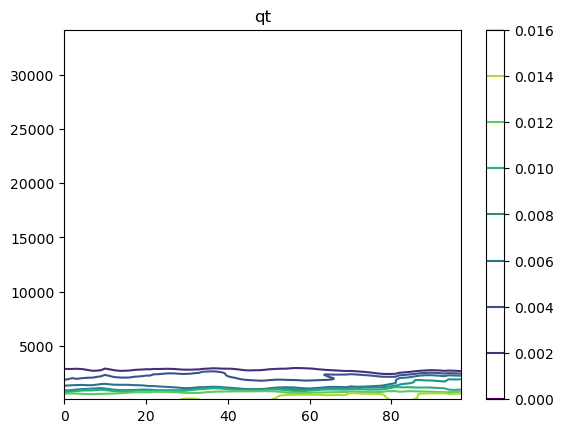

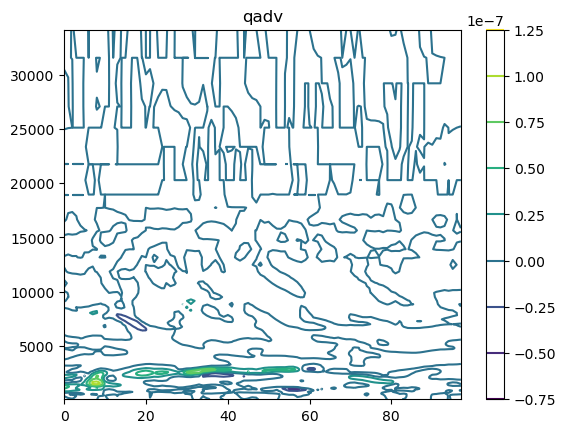

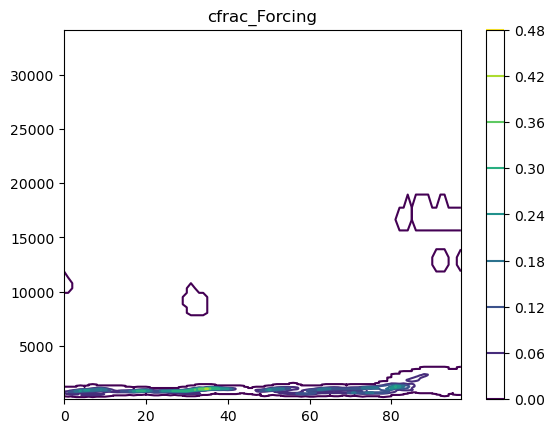

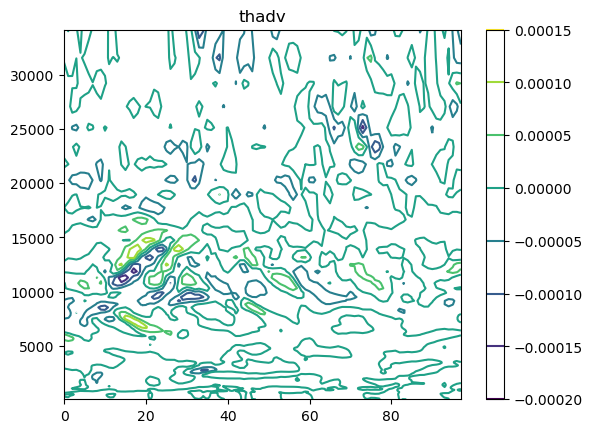

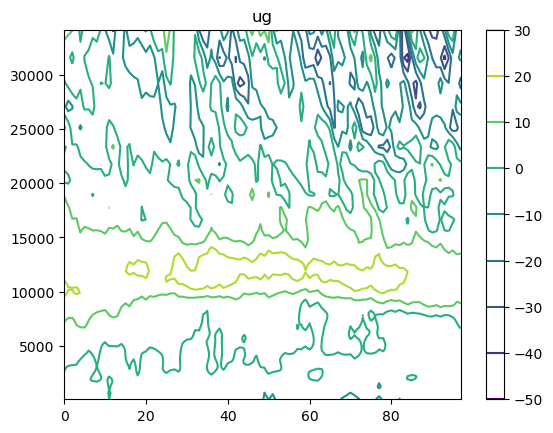

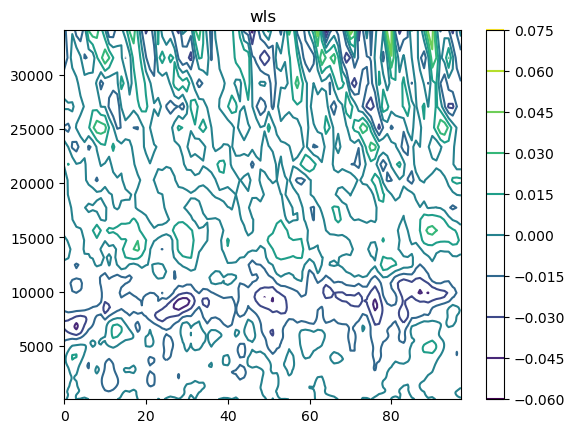

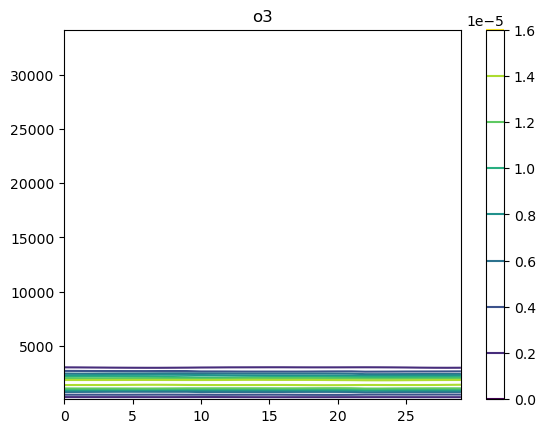

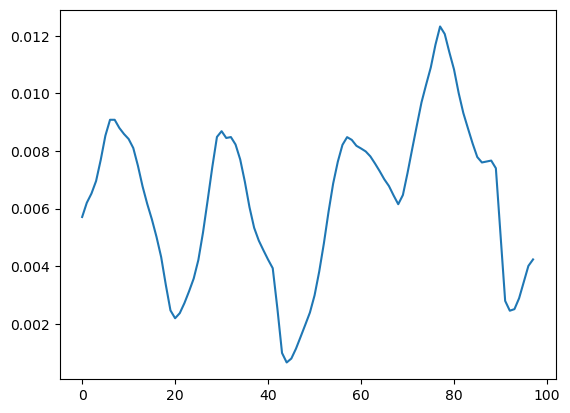

In [2]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import numpy as np
import metpy.calc as mpcalc
import metpy
import math
import statistics
from metpy.units import units
netcdf_path = '/home/girish/microhh/cases/eurec4a/forcings/scm_in.ECMWF-fc_EUREC4A_coor-Lagrangian-traj0-p950_domain2.0x2.0_20200205_ndays5_sfcERA5.nc'
netcdf_path='/data/eurec4a/data/forcings/eurec4a_20200202_first.kpt.nc'
all_data = xr.open_dataset(netcdf_path,decode_times=False)
ts = 0;
all_data = xr.open_dataset(netcdf_path,decode_times=False)
time = all_data['time'].values[0:];
tn=all_data['time'].values[:].size 
pres0_m=all_data['ps'].values[0:];
select_arr=np.logical_and(np.logical_not(np.isnan(pres0_m)),(time>=time[ts]))
time2 = time[select_arr]
qadv_un=all_data['qadv'].values[select_arr,:];         qadv_un=np.flip(qadv_un, axis=1);
tadv_un=all_data['tadv'].values[select_arr,:];         tadv_un=np.flip(tadv_un, axis=1);
time = all_data['time'].values[select_arr];
qt_un=all_data['q'].values[select_arr,:];              qt_un=np.flip(qt_un, axis=1);
ql_un=all_data['ql'].values[select_arr,:];             ql_un=np.flip(ql_un, axis=1)
pres_un=all_data['pres'].values[select_arr,:];         pres_un=np.flip(pres_un, axis=1)
pres0=all_data['ps'].values[select_arr];
sst=all_data['t_skin'].values[select_arr];
T_un=all_data['t'].values[select_arr,:];               T_un=np.flip(T_un, axis=1);
zun=all_data['zf'].values[select_arr,:];         zun=np.flip(zun, axis=1);
omega_un = all_data['omega'].values[select_arr,:];     omega_un=np.flip(omega_un, axis=1);
omg=all_data['sfc_lat_flx']; 
qad=all_data['qadv'];
mom_rough=all_data['mom_rough'].values; 
heat_rough=all_data['heat_rough'].values; 
q_skin=all_data['q_skin'].values[select_arr]; 
u_un=all_data['u'].values[select_arr,:];                   u_un=np.flip(u_un, axis=1);
v_un=all_data['v'].values[select_arr,:];                   v_un=np.flip(v_un, axis=1);
ug_un=all_data['ug'].values[select_arr,:];                   ug_un=np.flip(ug_un, axis=1);
vg_un=all_data['vg'].values[select_arr,:];                   vg_un=np.flip(vg_un, axis=1);
cloud_frac_un=all_data['cloud_fraction'].values[select_arr,:]; cloud_frac_un=np.flip(cloud_frac_un, axis=1);
o3_un=all_data['o3'].values[select_arr,:];                   o3=np.flip(o3_un, axis=1);
mean_height=all_data['orog'].values[:]; 
dz_fine = 40;
z_fine_top = 6000.;
k_fine = z_fine_top/dz_fine;
z1 = np.linspace(0.5*dz_fine, z_fine_top-0.5*dz_fine, int(k_fine));


print(time[0])
tttt=time[0]
z_coarse_top = 32001;
dz_coarse = 1000;
z2 = np.arange(z_fine_top, z_coarse_top, dz_coarse)
z = np.concatenate((z1, z2))

z_new=np.zeros(300)
z_abs=20
dz=40;
for i in range(0,z_new.size): 
    if i>150:
        dz=dz+int(round(0.1*dz,0));
    z_abs = z_abs+dz
    z_new[i] = z_abs;
z=z_new[0:195]
zh = 0.5*(z[:-1] + z[1:])
zh = np.append(0., zh)
zh = np.append(zh, z.size)

lon = all_data['lon'].values[select_arr]; #lon = 360 - lon;
lat = all_data['lat'].values[select_arr];
H=all_data['sfc_sens_flx'].values[select_arr];
L = all_data['sfc_lat_flx'].values[select_arr];
time = time - time[0];
time_full=all_data['date'].values;
qs=all_data['q_soil'].values[select_arr];
ts=all_data['t_soil'].values[select_arr];
hs=all_data['h_soil'].values;
u = np.zeros((time.size, z.size))
v = np.zeros((time.size, z.size))
ug = np.zeros((time.size, z.size))
vg = np.zeros((time.size, z.size))
th = np.zeros(np.shape(u))
thl   = np.zeros(np.shape(u))
thlls = np.zeros(np.shape(u))
pres = np.zeros(np.shape(u))
T = np.zeros(np.shape(u))
qt = np.zeros(np.shape(u))
ql = np.zeros(np.shape(u))
qadv=np.zeros(np.shape(u))
tadv=np.zeros(np.shape(u))
qtls=np.zeros(np.shape(u))
uls=np.zeros(np.shape(u))
vls=np.zeros(np.shape(u))
o3=np.zeros(np.shape(u))
qt_dqdt=np.zeros(np.shape(u))
omega = np.zeros(np.shape(u))
wls = np.zeros((time.size, z.size+1))
w = np.zeros(np.shape(u))
cloud_frac=np.zeros(np.shape(u))
sbotqt = np.zeros(time.size)
th_diff = np.zeros(time.size)
qt_diff = np.zeros(time.size)
U = np.zeros(time.size) 
fc = np.zeros(time.size)
cp  = 1005.
Lv  = 2.5e6
Rd  = 287.


for n in range(0,time.size):
    zun[n,:]=zun[n,:]-mean_height[n]
    interp_arr=(np.logical_not(np.isnan(zun[n,:])))
    qt[n,:] = np.interp(z,zun[n,interp_arr],qt_un[n,interp_arr])
    ql[n,:] = np.interp(z,zun[n,interp_arr],ql_un[n,interp_arr])
    qadv[n,:] = np.interp(z,zun[n,interp_arr],qadv_un[n,interp_arr])
    tadv[n,:] = np.interp(z,zun[n,interp_arr],tadv_un[n,interp_arr])
    pres[n,:] = np.interp(z,zun[n,interp_arr],pres_un[n,interp_arr])
    T[n,:] = np.interp(z,zun[n,interp_arr],T_un[n,interp_arr])
    omega[n,:] = np.interp(z,zun[n,interp_arr],omega_un[n,interp_arr])
    u[n,:] = np.interp(z,zun[n,interp_arr],u_un[n,interp_arr])
    v[n,:] = np.interp(z,zun[n,interp_arr],v_un[n,interp_arr])
    ug[n,:] = np.interp(z,zun[n,interp_arr],ug_un[n,interp_arr])
    vg[n,:] = np.interp(z,zun[n,interp_arr],vg_un[n,interp_arr])
    cloud_frac[n,:] = np.interp(z,zun[n,interp_arr],cloud_frac_un[n,interp_arr])
    o3[n,:] = np.interp(z,zun[n,interp_arr],o3_un[n,interp_arr])


######################################################################################
z_top = 70.e3
dz = 500.
z_rad  = np.arange(dz/2, z_top, dz)
z_rad = z_new
zh_rad = np.arange(   0, z_top-dz/2, dz)
zh_rad = np.append(zh_rad, z_top)

zh_rad = 0.5*(z_rad[:-1] + z_rad[1:])
zh_rad= np.append(0., zh_rad)
zh_rad = np.append(zh_rad, z_abs)

zun_rad=zun[0,:]-mean_height[0]
interp_rad=(np.logical_not(np.isnan(zun_rad)))
p_lay = np.interp(z_rad,zun_rad[interp_rad],pres_un[0,interp_rad])
p_lev = np.interp(zh_rad,zun_rad[interp_rad],pres_un[0,interp_rad])
T_lay = np.interp(z_rad,zun_rad[interp_rad],T_un[0,interp_rad])
T_lev = np.interp(zh_rad,zun_rad[interp_rad],T_un[0,interp_rad])
qt_rad=np.zeros(z_rad.size); o3_rad=np.zeros(z_rad.size);
qt_rad[:] = np.interp(z_rad,zun_rad[interp_rad],qt_un[0,interp_rad])
######################################################################################

p_sbot = pres0;
for n in range(0,time.size):
    sat_r = mpcalc.saturation_mixing_ratio(pres0[n] * units.pascal , sst[n]* units.kelvin)
    fc[n] = mpcalc.coriolis_parameter(lat[n]*units.degrees) * units.second
    fc_cal = mpcalc.coriolis_parameter(14*units.degrees) * units.second
    sbotqt[n] = mpcalc.specific_humidity_from_mixing_ratio(sat_r)
    for k in range(0,z.size):
        mix_ratio = mpcalc.mixing_ratio_from_specific_humidity(qt[n,k])
        w[n,k] = mpcalc.vertical_velocity(omega[n,k] * units.pascal / units.second, pres[n,k] * units.pascal, T[n,k] * units.kelvin, mix_ratio) / (units.meter / units.second)
        th[n,k] = mpcalc.potential_temperature(pres[n,k] * units.pascal, T[n,k] * units.kelvin) / units.kelvin
        thl[n,k] = th[n,k] - (th[n,k]/T[n,k]) * (Lv/cp) * (ql[n,k]/(1-qt[n,k]))

print(fc_cal)
tv = T * (1 + 0.61 * qt)
rho_arr = pres / (Rd * tv)
thlin = T * (1.e5/pres)**(Rd/cp)
win = -omega / (rho_arr*9.81)

for n in range(0,time.size-1):
    thlls[n,:] = (th[n+1,:]-th[n,:])/(time[n+1]-time[n])
    qtls[n,:] = (qt[n+1,:]-qt[n,:])/(time[n+1]-time[n])
    uls[n,:] = (u[n+1,:]-u[n,:])/(time[n+1]-time[n])
    vls[n,:] = (v[n+1,:]-v[n,:])/(time[n+1]-time[n])
    wls_un = (w[n+1,:]-w[n,:])/(time[n+1]-time[n])
    wls[n,:] = np.interp(zh,z,wls_un)
wls[time.size-1,:] = wls[time.size-2,:]
uls[time.size-1,:] = uls[time.size-2,:]
vls[time.size-1,:] = vls[time.size-2,:]
qtls[time.size-1,:] = qtls[time.size-2,:]
thlls[time.size-1,:] = thlls[time.size-2,:]
qt_dqdt[0,:] = qt[0,:];
for i in range(0,time.size-1):
    for j in range(0,z.size):
        qt_dqdt[i+1,:] = qt_dqdt[i,:] + qtls[i,:] * (time[n+1]-time[n])

##### Fluxes ################
Ch=0.001094; Cq=0.001133
rhosurf = pres0 / (Rd * sst * (1. + 0.61 * q_skin))
qtbot = -L / (rhosurf * Lv) #J/m2s / (J/m3) --> m/s
sbotthl = -H / (rhosurf * cp) # K m/s
ths = sst / (p_sbot/1.e5)**(287.04/1005.)


for n in range(time.size):
    th_diff[n] = th[n,0]-ths[n]
    qt_diff[n] = qt[n,0]-q_skin[n]
    U[n]=math.sqrt(u[n,0]**2+v[n,0]**2)

sh_flx = -Ch * U * th_diff
lat_flx = -Cq * U * qt_diff
aa = thlls/tadv

z_plot=220
pl.figure()
pl.contour(time/3600,z[0:z_plot],np.transpose(qt[:,0:z_plot]))
pl.title('qt')
pl.colorbar()

pl.figure()
pl.contour(time/3600,z[0:z_plot],np.transpose(qadv[:,0:z_plot]))
pl.title('qadv')
pl.colorbar()

pl.figure()
pl.contour(time[:]/3600,z[0:z_plot],np.transpose(cloud_frac[:,0:z_plot]))
pl.title('cfrac_Forcing')
pl.colorbar()

pl.figure()
pl.contour(time[:]/3600,z[0:z_plot],np.transpose(tadv[:,0:z_plot]))
pl.title('thadv')
pl.colorbar()

pl.figure()
pl.contour(time[:]/3600,z[0:z_plot],np.transpose(ug[:,0:z_plot]))
pl.title('ug')
pl.colorbar()

pl.figure()
pl.contour(time/3600,z[0:z_plot],np.transpose(w[:,0:z_plot]))
pl.title('wls')
pl.colorbar()


pl.figure()
pl.contour(time[0:30]/3600,z[:],np.transpose(o3[0:30,:]))
pl.title('o3')
pl.colorbar()

pl.figure()
pl.plot(sbotthl)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TITLE: AUXILIARY FORCING FOR CRM
    SOURCE: varanarap-v20161129/sgp60varanarapC1.c1.20160601.000000.cdf
    dimensions(sizes): Time(31), DateStrLen(19)
    variables(dimensions): |S1 Times(Time, DateStrLen), float32 PRE_SH_FLX(Time), float32 PRE_LH_FLX(Time), float32 PRE_TSK(Time), float32 PRE_ALBEDO(Time), float32 PRE_SH_FLX_TEND(Time), float32 PRE_LH_FLX_TEND(Time), float32 PRE_TSK_TEND(Time), float32 PRE_ALBEDO_TEND(Time)
    groups: 


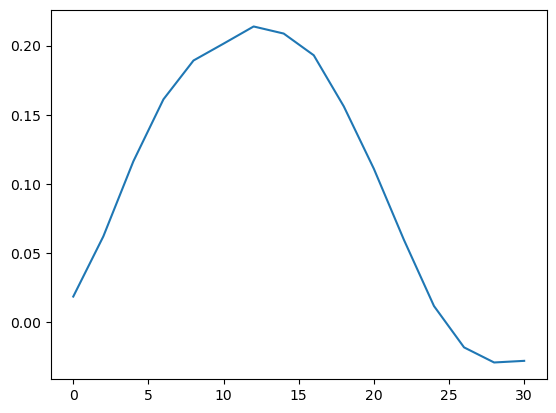

In [13]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

fname_in = "/home/girish/microhh/cases/lasso/20160611/config/input_sfc_forcing.nc"
f = nc.Dataset(fname_in, 'r+')
print(f)
data_a=xr.open_dataset(fname_in,decode_times=False)
H_in = data_a['PRE_SH_FLX'].values
LE_in = data_a['PRE_LH_FLX'].values
Times=data_a['Times'].values

H = data_a['PRE_SH_FLX']
rhosurf = 101480 / (287 * 300 * (1. + 0.61 * 0.018)) #(kg m s^-2 / J kg^-1)
sbotthl = H_in / (rhosurf * 1005)
qt_sbot = LE_in / (rhosurf * 2.5e6)

pl.figure()
pl.plot(sbotthl)

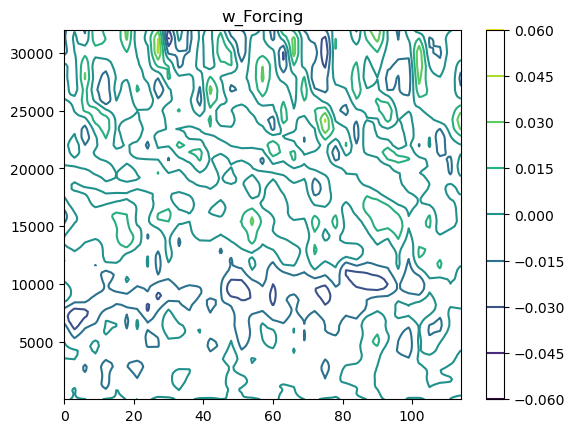

In [4]:
pl.figure()
pl.contour(time/3600,z,np.transpose(w))
pl.title('w_Forcing')
pl.colorbar()